#### Профильное задание на стажировку

Начинаем работу :)

In [1]:
# Сделаем необходимые импорты и загрузим данные
import pandas as pd
import numpy as np 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
import re

train = pd.read_csv("train_spam.csv")

#### EDA

In [2]:
train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [3]:
train.shape

(16278, 2)

In [4]:
train.isna().sum()

text_type    0
text         0
dtype: int64

Посмотрим на рспределение классов 

<Axes: xlabel='text_type'>

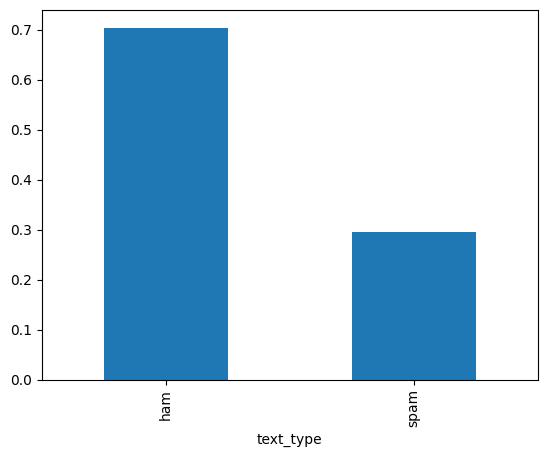

In [5]:
train['text_type'].value_counts(normalize = True).plot.bar()

Видно, что неСПАМа больше

Построим WordCloud для обоих классов

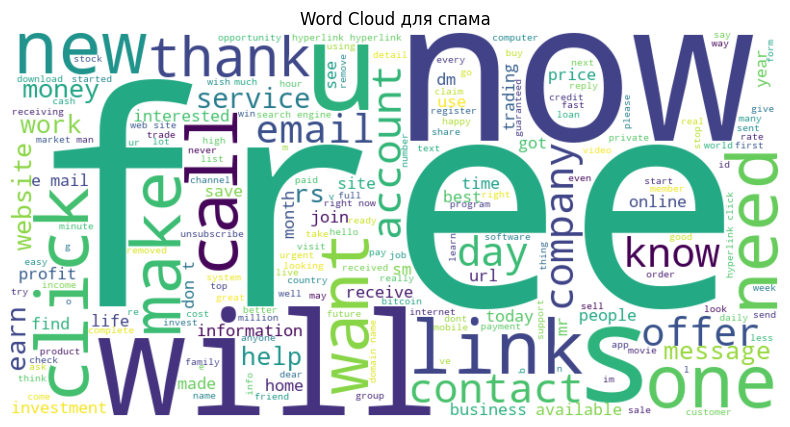

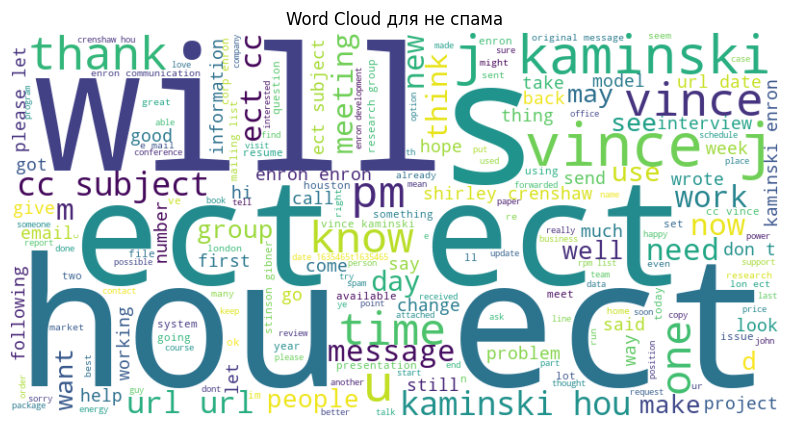

In [6]:
spam_text = ' '.join(train[train['text_type'] == 'spam']['text'])
ham_text = ' '.join(train[train['text_type'] == 'ham']['text'])

wordcloud_spam = WordCloud(width=800, height=400, background_color ='white').generate(spam_text)
wordcloud_ham = WordCloud(width=800, height=400, background_color ='white').generate(ham_text)
 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Word Cloud для спама')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Word Cloud для не спама')
plt.axis('off')
plt.show()

Видно, что в WordCloud для спама особенно сильно выделяются рекламные/лозунговые слова:
'free', 'now', 'new' и др. 

Создадим функцию для отчистки текста

In [7]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    
    text = text.lower() # Преобразование текста в нижний регистр
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # Удаление небуквенных символов и замена их на пробелы
    text = re.sub(r"http\S+", "",text)  # Удаление ссылок
 
    # Удаление HTML-тегов
    html=re.compile(r'<.*?>') 
    text = html.sub(r'',text)  
    
    # Удаление знаков пунктуации
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') 

    # Токенизация текста, удаление стоп-слов и лемматизация
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)  

    # Удаление эмодзи
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # смайлики 
                           u"\U0001F300-\U0001F5FF"  # символы и пиктограммы 
                           u"\U0001F680-\U0001F6FF"  # символы транспорта и картинки 
                           u"\U0001F1E0-\U0001F1FF"  # флаги (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)  
    
    return text

In [8]:
train['text'] = train['text'].apply(lambda x: clean_text(x)) # Применяем функцию для отчистки текста
train.head()

,text_type,text
0,ham,make sure alex know birthday fifteen minute fa...
1,ham,resume john lavorato thanks vince get moving r...
2,spam,plzz visit website moviesgodml get movie free ...
3,spam,urgent mobile number awarded prize guaranteed ...
4,ham,overview hr associate analyst project per davi...


Переходим непосредтвенно к классификации

#### TF-IDF

Сначала опробуем tf-idf векторизацию текста. Используем tf-idf фичи для обучения случайного леса

In [9]:
# Сделаем необходимые импорты
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [10]:
# Разделим нашу выборку на train и test
X_train, X_test , y_train, y_test = train_test_split(train['text'].values,
                                                     train['text_type'].values,
                                                     test_size=0.2,random_state=123,
                                                     stratify=train['text_type'].values)

In [11]:
# Сделаем tf-id векторизацию
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

In [12]:
# Обучим случайный лес и сделаем предсказние
clf = RandomForestClassifier()
clf.fit(tfidf_train_vectors, y_train)
y_pred = clf.predict_proba(tfidf_test_vectors)

In [13]:
roc_auc_score(y_test, y_pred[:, 1]) # Вычислим roc-auc метрику

0.9479393047396535

Получили 0.947. Неплохо, но попробуем ещё подходы

#### CatBoost

У CatBoost есть парамет text_feature, который позволяет предобрабатывать текстовые фичи 

In [14]:
from catboost import Pool, CatBoostClassifier

In [15]:
# Добавим новую фичу(длина текста), чтобы выучить больше информации
def length_text(row):
    splitted_text = row['text'].split()
    return len(splitted_text)

train['length_of_text'] = train.apply(length_text, axis = 1)

In [16]:
X, y = train.drop('text_type', axis = 1), train['text_type']

In [17]:
X_train, X_test , y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size=0.2,random_state=123,
                                                     stratify=train['text_type'].values)
text_features = ['text'] # Укажем название текстовой фичи для обучения

In [19]:
# Используем специальный класс Pool из библиотеки catboost, для подготовки данных
# Укажем так же text_features в параметрах
train_pool = Pool(
    X_train, 
    y_train, 
    text_features=text_features, 
    feature_names=list(X_train)
)
valid_pool = Pool(
    X_test, 
    y_test,
    text_features=text_features, 
    feature_names=list(X_train)
)

In [20]:
# Зададим параметры классификатора и запустим обучение
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'eval_metric': 'AUC', # Задаём метрику ROC-AUC для оценки 
    'task_type': 'GPU',
    'early_stopping_rounds': 20,
    'use_best_model': True,
    'verbose': 50
}

model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9601192	best: 0.9601192 (0)	total: 45.1ms	remaining: 45.1s
50:	test: 0.9732485	best: 0.9732938 (46)	total: 1.81s	remaining: 33.6s
100:	test: 0.9745338	best: 0.9748503 (86)	total: 3.58s	remaining: 31.9s
bestTest = 0.9748503268
bestIteration = 86
Shrink model to first 87 iterations.


In [21]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1]) # Посчитаем метрику

0.9748503281633186

Получили 0.9749. Рузельтат сильно улучшился. Но можно ещё улучшить

#### BERT

Переходим к нейросетевому подходу. Используем BERT для классификации текста

Обучение я делал на Kaggle (локально не хватило мощностей), но код для подготовки данных и обучения идентичен

In [22]:
train = pd.read_csv("train_spam.csv")

train['text_type'] = train['text_type'].map({'ham':0, 'spam':1}) # Закодируем наш таргет, потому что BERT принимает
train.rename({'text_type': 'label'}, axis = 1, inplace = True) # закодированный таргет с названием 'label'
train['text'] = train['text'].apply(lambda x: clean_text(x))

In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Загрузим модель с Hugging Face
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from datasets import Dataset

# Разделим наши данные тренировочные, тестовые и валдиационные
train_data_df, temp_data_df = train_test_split(train, test_size=0.25, random_state=42)
eval_data_df, test_data_df = train_test_split(temp_data_df, test_size=0.5, random_state=42)

train_dataset = Dataset.from_pandas(train_data_df)
eval_dataset = Dataset.from_pandas(eval_data_df)
test_dataset = Dataset.from_pandas(test_data_df)

In [25]:
# Подготовим наши данные с помощью токенайзера
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets_train = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets_eval = eval_dataset.map(tokenize_function, batched=True)
tokenizer_datasets_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/12208 [00:00<?, ? examples/s]

Map:   0%|          | 0/2035 [00:00<?, ? examples/s]

Map:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [26]:
# Напишем функцию для подсчёта метрики на валидации
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probas = torch.sigmoid(torch.tensor(logits[:,1]))
    roc_auc = roc_auc_score(labels, probas)
    return {"roc_auc": roc_auc}    

Здесь задаём параметры для обучения. Обучал 5 эпох c размером батча 16

In [28]:
from transformers import TrainingArguments,Trainer

batch_size= 16
training_args = TrainingArguments(output_dir="bert_trainer_new", 
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                  num_train_epochs=5,
                                evaluation_strategy="epoch",
                                 push_to_hub=False)

'''
training_args = TrainingArguments(output_dir="/kaggle/working/bert_trainer_new", 
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                  num_train_epochs=5,
                                evaluation_strategy="epoch",
                                 push_to_hub=False)
'''

In [31]:
# Запускаем обучение 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_eval,
    compute_metrics=compute_metrics
)
trainer.train()

Это скриншот с Kaggle с результатами обучения

![img](bert.png)

Модель сохранил в "bert_model", чтобы затем можно было использовать локально. Ссылку на веса я приложу на GitHub

In [42]:
model = AutoModelForSequenceClassification.from_pretrained('bert_model',num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args
)

In [46]:
predictions_output = trainer.predict(tokenizer_datasets_test) # Делаем предсказние 
predictions_output

  0%|          | 0/255 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 4.3307905, -4.7662797],
       [ 4.3228087, -4.853657 ],
       [ 4.2942696, -4.7788405],
       ...,
       [ 4.2844872, -4.807973 ],
       [-3.2731218,  3.3687794],
       [-3.0456684,  3.1492667]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 1, 0], dtype=int64), metrics={'test_loss': 0.24843692779541016, 'test_runtime': 791.198, 'test_samples_per_second': 2.572, 'test_steps_per_second': 0.322})

In [47]:
probas = torch.sigmoid(torch.tensor(predictions_output[0][:, 1]))
roc_auc_score(tokenizer_datasets_test['label'], probas) # Считаем метрику

0.983570131049695

Видно, что BERT показал себя лучше всего, поэтому для финального предскзания на test используем его

#### Test Inference

In [54]:
test = pd.read_csv("test_spam.csv")
test['text'] = test['text'].apply(lambda x: clean_text(x))

test_dataset = Dataset.from_pandas(test)
tokenized_test = test_dataset.map(tokenize_function)

Map:   0%|          | 0/4070 [00:00<?, ? examples/s]

In [55]:
model = AutoModelForSequenceClassification.from_pretrained('bert_model',num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args
)

In [56]:
preds = trainer.predict(tokenized_test)

  0%|          | 0/509 [00:00<?, ?it/s]

In [57]:
positive_class_probs = preds.predictions[:, 1]
scores = torch.sigmoid(torch.tensor(positive_class_probs))

In [58]:
submission = pd.DataFrame({"text": test['text'],
                           "score": scores})

In [61]:
submission.to_csv("submit.csv", index=False)